# MicroTPCT – Algorithm Benchmark Notebook

This notebook benchmarks multiple exact matching algorithms for MicroTPCT.
It measures execution time, CPU usage, peak memory consumption, and validates
correctness against a controlled synthetic ground truth.

## Introduction

This benchmark evaluates several peptide-to-proteome exact matching strategies
implemented in MicroTPCT. The objectives are:

* Compare execution time, CPU usage, and memory consumption.
* Verify correctness against a known ground truth.
* Illustrate algorithmic behavior under different controlled scenarios.
* Provide guidance for default algorithm selection and user-level configuration.

Algorithms compared include:

* Naive str.find baseline
* Boyer–Moore
* Aho–Corasick (Python)
* Aho–Corasick (Rust)
* grep + awk launcher
* BLAST (reference but overkill)

## 1. Imports and configuration

In [ ]:
from typing import Callable, Dict, List

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from microtpct.utils.data_generator import generate_benchmark_databases
from microtpct.core.match import MATCHING_ENGINES

from benchmark.benchmark_core import BenchmarkResult, run_benchmark

## 2. Register algorithms

Replace or extend this dictionary with your real implementations.

In [ ]:
print(MATCHING_ENGINES)

## 3. Benchmark scenarios

We define a small but illustrative set of scenarios designed to expose algorithmic differences without performing an exhaustive grid search.

In [ ]:
SCENARIOS = {
    "small_sparse": dict(
        n_proteins=1000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=1000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.05,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=1,
    ),

    "many_queries": dict(
        n_proteins=5000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=20000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.1,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=2,
    ),

    "short_peptides": dict(
        n_proteins=2000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=3000,
        peptide_mean_length=6,
        peptide_std_length=1,
        match_fraction=0.3,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=3,
    ),

    "negative_only": dict(
        n_proteins=5000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=5000,
        peptide_mean_length=10,
        peptide_std_length=2,
        match_fraction=0.0,
        quasi_fraction=0.0,
        redundancy_rate=0.0,
        mutation_rate=0.0,
        seed=4,
    ),

    "repetitive": dict(
        n_proteins=2000,
        protein_mean_length=300,
        protein_std_length=50,
        x_rate=0.0,
        n_peptides=1000,
        peptide_mean_length=7,
        peptide_std_length=1,
        match_fraction=0.8,
        quasi_fraction=0.0,
        redundancy_rate=0.3,
        mutation_rate=0.05,
        seed=5,
    ),
}

## 7. Main benchmark loop

In [ ]:
all_results: List[BenchmarkResult] = []

for scenario_name, params in SCENARIOS.items():
    print(f"Running scenario: {scenario_name}")

    target_db, query_db, ground_truth, config = generate_benchmark_databases(**params)

    for algo_name, algo_func in ALGORITHMS.items():
        print(f"  Algorithm: {algo_name}")

        res = run_benchmark(
            algorithm_name=algo_name,
            run_method=algo_func,
            scenario_name=scenario_name,
            target_db=target_db,
            query_db=query_db,
            ground_truth=ground_truth,
        )

        all_results.append(res)

# Convert to DataFrame

df = pd.DataFrame([r.__dict__ for r in all_results])
df

## 8. Sanity check: correctness

In [ ]:
assert df["valid"].all(), "Some algorithms produced incorrect results"

## 9. Visualization – Execution time

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="algorithm", y="wall_time", hue="scenario")
plt.ylabel("Wall time (s)")
plt.title("Execution time per algorithm and scenario")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Visualization – Peak memory

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="algorithm", y="peak_memory_mb", hue="scenario")
plt.ylabel("Peak memory (MB)")
plt.title("Peak memory consumption per algorithm and scenario")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Visualization – Scaling behavior

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="n_queries", y="wall_time", hue="algorithm", style="scenario", markers=True)
plt.xlabel("Number of queries")
plt.ylabel("Wall time (s)")
plt.title("Scaling with number of peptides")
plt.tight_layout()
plt.show()

## 13. Key observations (to be completed)

* Scenario: small_sparse

  * [Placeholder: comment on relative speed and overhead]

* Scenario: short_peptides

  * [Placeholder: collision behavior, advantage of multi-pattern algorithms]

* Scenario: negative_only

  * [Placeholder: worst-case scanning cost]

In [ ]:
from pathlib import Path


FIGURES_DIR = Path("figures")
FIGURES_DIR.mkdir(exist_ok=True)


def save_fig(name, dpi=300):
path = FIGURES_DIR / f"{name}.png"
plt.savefig(path, bbox_inches="tight", dpi=dpi)
print(f"Saved figure → {path}")

## 14. Summary table

In [ ]:
summary = (
    df.groupby(["algorithm"])
      .agg({
          "wall_time": "mean",
          "peak_memory_mb": "mean",
          "cpu_user_time": "mean",
          "valid": "all",
      })
      .reset_index()
)
summary

## 15. Conclusion (template)

This benchmark highlights several key findings:

* The naive str.find implementation provides a reliable but slow baseline.
* Multi-pattern algorithms (Aho–Corasick) scale better with increasing numbers of queries.
* System-level tools (grep/awk) offer competitive performance with minimal memory overhead.
* BLAST, while robust, is computationally overkill for exact peptide matching.

Based on these results, we recommend:

* Default algorithm: [TO FILL]
* Use cases favoring alternative methods: [TO FILL]

These results justify the default configuration of MicroTPCT and provide users
with practical guidance for selecting an appropriate matching engine.

### Installation of required packages

In [1]:
! pip install psutil pandas pynvml tqdm line_profiler matplotlib seaborn
! pip install pyahocorasick Bio pybmoore ahocorasick_rs

# pip install requirements.txt

### bash commands makeblastdb and blastp must be installed and on PATH
# sudo apt update
# sudo apt install ncbi-blast+

### Imports and initialization

In [2]:
#import pytest
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

import tempfile
import time
import psutil
import logging
import os
import sys
import platform

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

from Bio import SeqIO #type: ignore

#boyer moore specific imports
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

### Data for benchmarking

#### Peptide and proteome data loading - IF BENCHMARKING ON EXISTING DATA

In [9]:
def load_peptides_txt(path):
    with open(path) as f:
        return [l.strip() for l in f if l.strip()]

def load_proteome_fasta(path):
    """
    Retourne une liste de tuples (protein_id, sequence)
    """
    return [(rec.id, str(rec.seq)) for rec in SeqIO.parse(path, "fasta")]

peptides = load_peptides_txt("Peptides.txt")

proteome = load_proteome_fasta(
    "uniprotkb_proteome_UP000000803_2025_11_25.fasta"
)

proteome_fasta_path = "uniprotkb_proteome_UP000000803_2025_11_25.fasta"

# Boyer-Moore expects (id, seq)
queries = [(pep, pep) for pep in peptides]  # id = sequence

# Creation of a temporary fasta file for the proteome
proteome_fasta_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta')
records = [SeqRecord(Seq(seq), id=pid) for pid, seq in proteome]
SeqIO.write(records, proteome_fasta_file.name, "fasta")
proteome_fasta_file.close()


#### Random data from data_generator.py - GENERATING DATA TO BENCHMARK 

Generates benchmark databases with realistic parameters (100 proteins, 200 peptides with 50% matching)
Extracts the sequences in formats compatible with your existing benchmark functions
Creates the temporary FASTA file for algorithms that need it
Prints summary information about what was generated
You can adjust the parameters (n_proteins, n_peptides, match_fraction, etc.) as needed for your benchmarks.

In [16]:
from data_generator import generate_benchmark_databases

# Generate benchmark databases with controlled parameters
target_db, query_db = generate_benchmark_databases(
    n_proteins=100,
    protein_mean_length=200,
    protein_std_length=50,
    x_rate=0.01,
    
    n_peptides=200,
    peptide_mean_length=10,
    peptide_std_length=3,
    match_fraction=0.5,
    
    seed=123,
)

# Extract data in formats compatible with benchmark functions
proteome = [(acc, seq) for acc, seq in zip(target_db.accessions, target_db.sequences)]
peptides = [seq for seq in query_db.sequences]

# Boyer-Moore expects (id, seq)
queries = [(pep, pep) for pep in peptides]

# Creation of a temporary fasta file for the generated proteome
proteome_fasta_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.fasta')
records = [SeqRecord(Seq(seq), id=f"seq_{i}") for i, (pid, seq) in enumerate(proteome)]
SeqIO.write(records, proteome_fasta_file.name, "fasta")
proteome_fasta_file.close()

# Set path to the temporary fasta file
proteome_fasta_path = proteome_fasta_file.name

print(f"Generated {len(peptides)} peptides and {len(proteome)} proteins")
print(f"Proteome FASTA file: {proteome_fasta_path}")

Generated 200 peptides and 100 proteins
Proteome FASTA file: /tmp/tmpidh8pp2o.fasta


### Matching algorithms to benchmark 

In [17]:
from bench_functions import (
    run_ahocorasick_mem,
    run_ahocorasick_rs_mem,
    run_find_mem,
    run_in_mem,
    run_blast_mem,
    run_boyermoore_parallel_mem,
    run_grawk_mem2
    )


TESTS = [
    (run_ahocorasick_mem, (peptides, proteome)),  # tuple -> argument
    (run_ahocorasick_rs_mem, (peptides, proteome)),
    (run_find_mem, (peptides, proteome)),
    (run_in_mem, (peptides, proteome)),
    (run_blast_mem, (peptides, proteome_fasta_path)),
    (run_boyermoore_parallel_mem, (queries, proteome_fasta_file.name)),
    (run_grawk_mem2, (peptides, proteome))
]

In [18]:
# Check WSL availability
#if platform.system() == "Windows":
    #try:
        #subprocess.run(["wsl", "--version"], capture_output=True, check=True, timeout=5)
        #TESTS.append((run_grawk_mem_wsl, (peptides, proteome)))
        #print("✓ WSL detected")
    #except (FileNotFoundError, subprocess.TimeoutExpired):
        #print("⚠ WSL not available - skipping grawk_mem_wsl")

In [19]:
# Logging configuration: write execution details to a log file
logging.basicConfig(
    filename="benchmark.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

process = psutil.Process()

### Single-run measurement utility

In [20]:
def run_once(fn, *args, **kwargs):
    """
    Execute a function once and collect basic timing and memory information.
    This is decorator-free to ensure functions remain pickleable.
    """
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()

    mem = process.memory_info().rss / 1e6

    return {
        "time_seconds": t1 - t0,
        "memory_used_MB": mem,
        "result": result
    }

### Multi-run wrapper (manual loop)

In [21]:
def benchmark(fn, runs=5, args=()):
    """
    Run a function several times with positional arguments and compute average runtime.
    No decoration or wrapping done, to keep fn pickleable.
    """
    records = []
    for _ in range(runs):
        rec = run_once(fn, *args)  # unpacks the tuple
        records.append(rec)

    avg_time = sum(r["time_seconds"] for r in records) / len(records)

    return {
        "function": fn.__name__,
        "args": args,
        "time_mean": avg_time,
    }



### Sequential execution (should take 1 (or 2 minutes) max)

In [22]:
results_seq = []
for fn, params in TESTS:
    res = benchmark(fn, runs=10, args=params)  # <- args=params, no *
    logging.info(f"[SEQ] {res}")
    results_seq.append(res)

df_seq = pd.DataFrame(results_seq)
df_seq


,function,args,time_mean
0,run_ahocorasick_mem,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.000612
1,run_ahocorasick_rs_mem,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.000658
2,run_find_mem,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.005633
3,run_in_mem,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.002876
4,run_blast_mem,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.135607
5,run_boyermoore_parallel_mem,"([(TQIHVIVLNDT, TQIHVIVLNDT), (RETHWCRST, RETH...",3.694163
6,run_grawk_mem2,"([TQIHVIVLNDT, RETHWCRST, MKWFCAQYMMALSLQ, END...",0.455052


### Metrics

In [23]:
def run_single_with_metrics(test):
    func, args = test # args can be a tuple or a dict
    if isinstance(args, dict):
        args = (args.get("size", 0),)  # -> tuple
    elif not isinstance(args, tuple):
        args = (args,)  # transform in tuple if only 1 argument

    proc = psutil.Process(os.getpid())
    cpu_start = psutil.cpu_percent(interval=None)
    mem_start = proc.memory_info().rss / (1024*1024)  # MB

    import time
    start = time.time()
    result = func(*args)
    end = time.time()

    cpu_end = psutil.cpu_percent(interval=None)
    mem_end = proc.memory_info().rss / (1024*1024)  # MB

    return {
        "result": result,
        "time_sec": end - start,
        "cpu_mean": cpu_end - cpu_start,
        "mem_mean_MB": mem_end - mem_start
    }

### DataFrame creation

In [24]:
# parallel execution with ThreadPoolExecutor (safe in Jupyter)
with ThreadPoolExecutor(max_workers=cpu_count()) as exe:
    results = list(exe.map(run_single_with_metrics, TESTS))

df_parallel = pd.DataFrame({
    "function": [t[0].__name__ for t in TESTS],
    "argument": [t[1] for t in TESTS],
    "result": [r["result"] for r in results],
    "time_sec": [r["time_sec"] for r in results],
    "cpu_mean": [r["cpu_mean"] for r in results],
    "mem_mean_MB": [r["mem_mean_MB"] for r in results]
})

print(df_parallel.columns)

Index(['function', 'argument', 'result', 'time_sec', 'cpu_mean',
       'mem_mean_MB'],
      dtype='object')


### Visualisation of results (boxplot + violin)

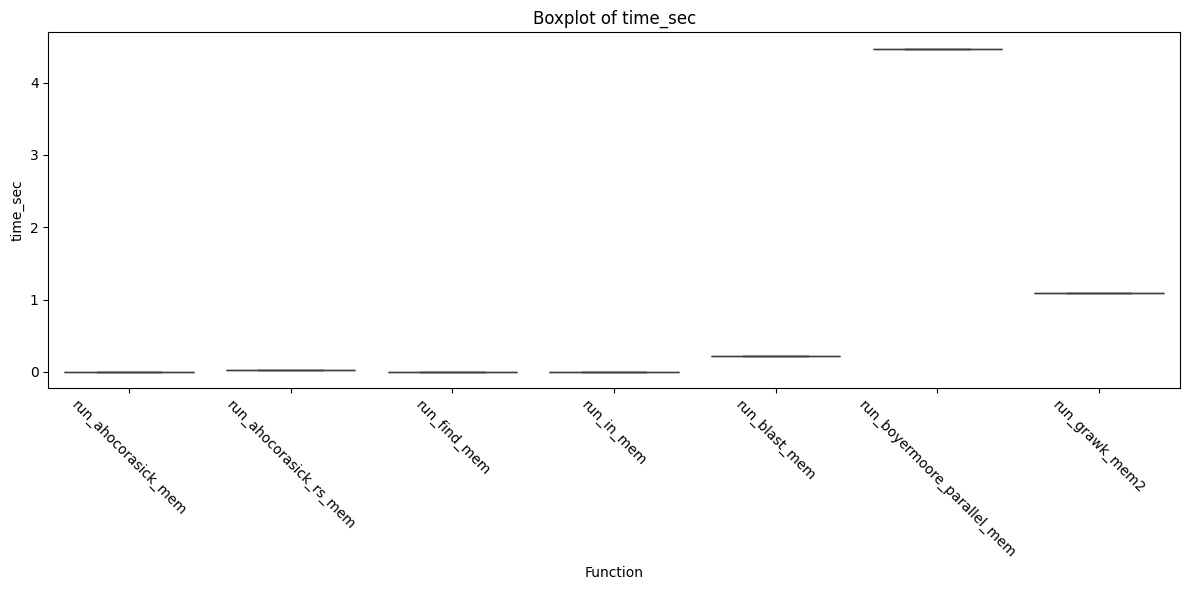

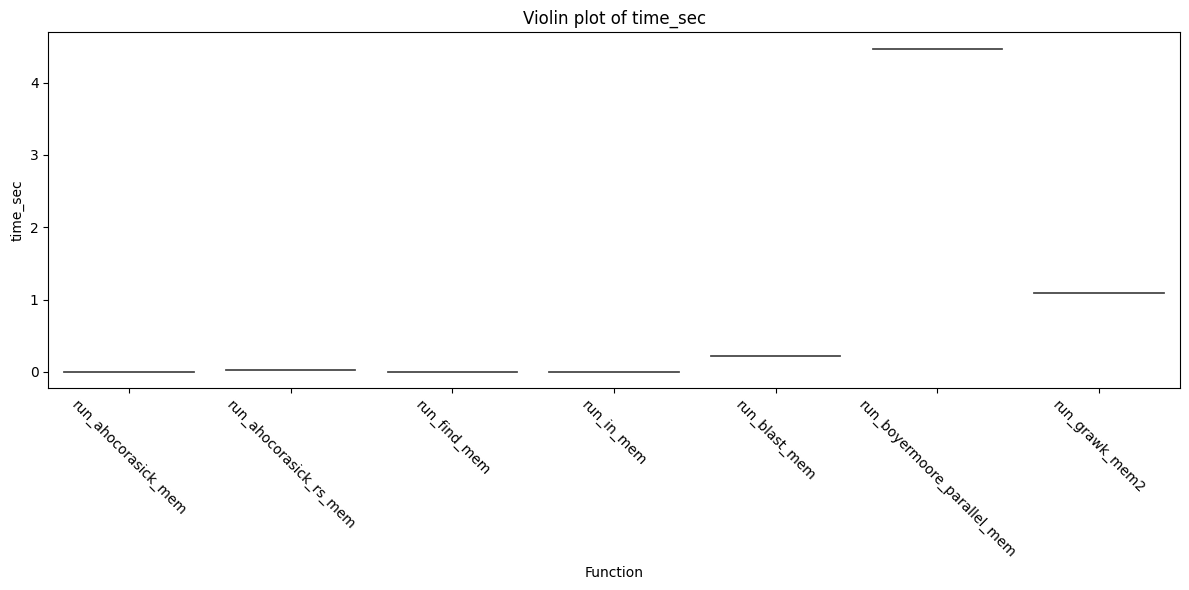

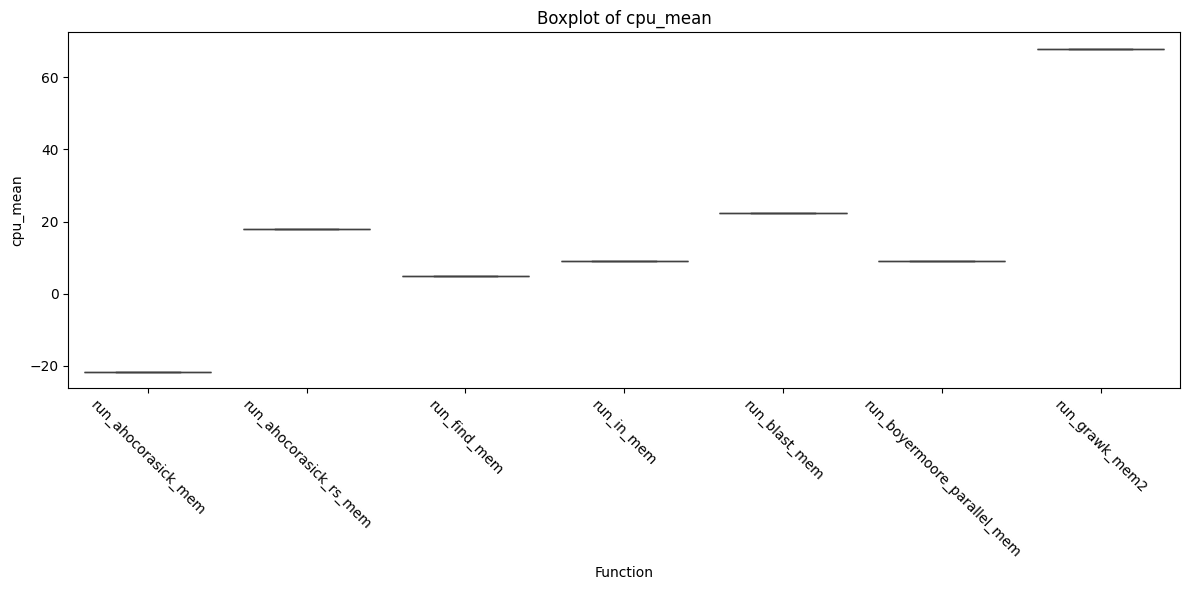

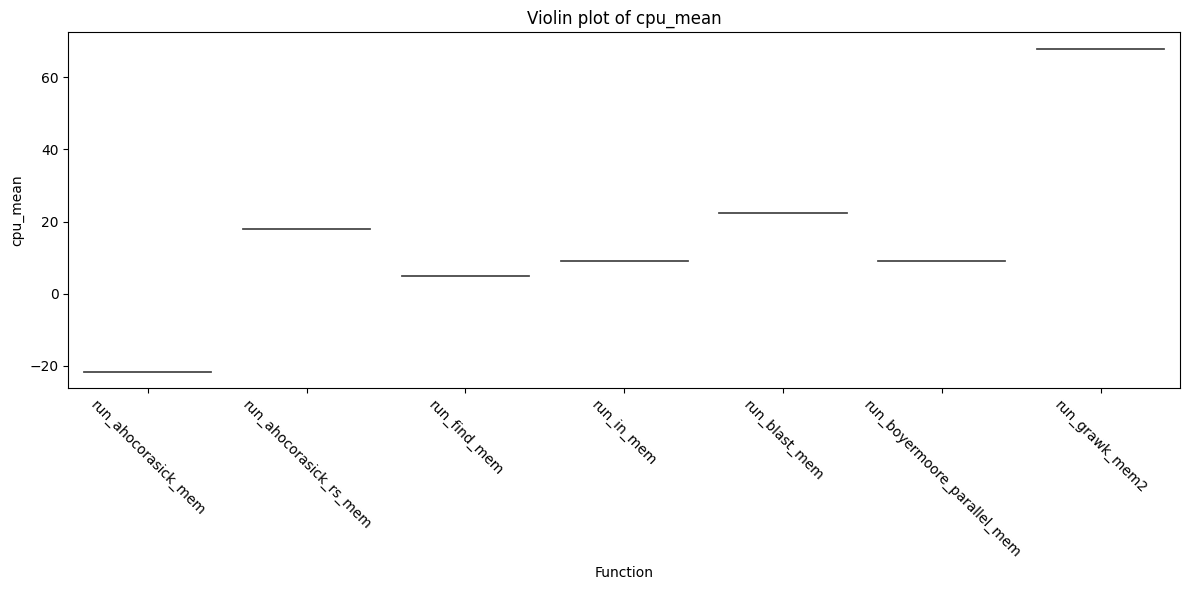

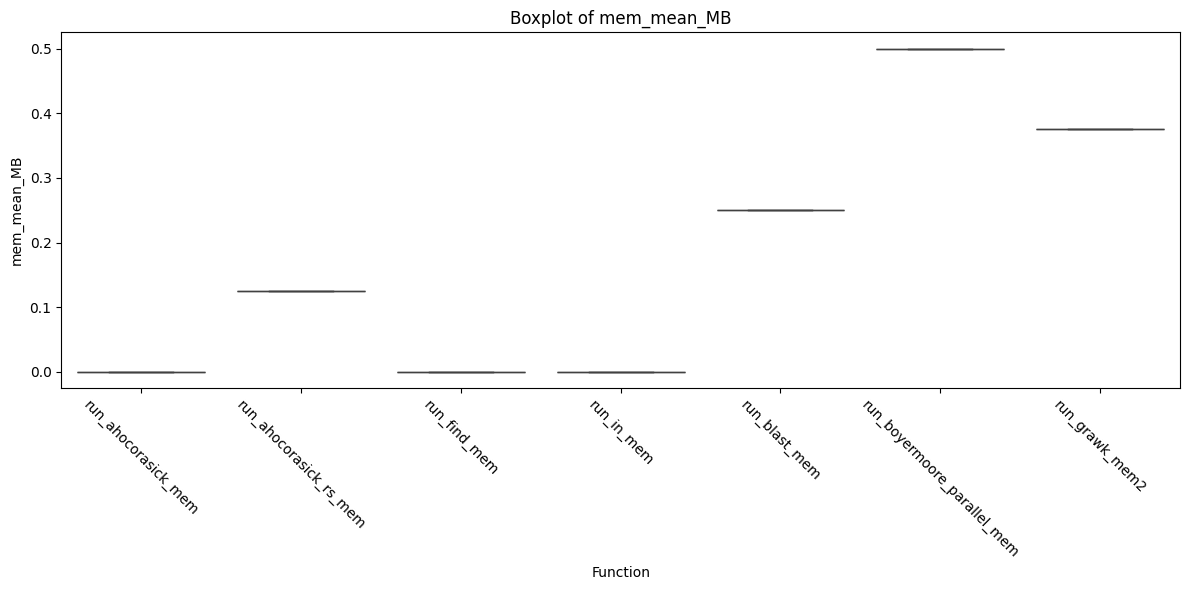

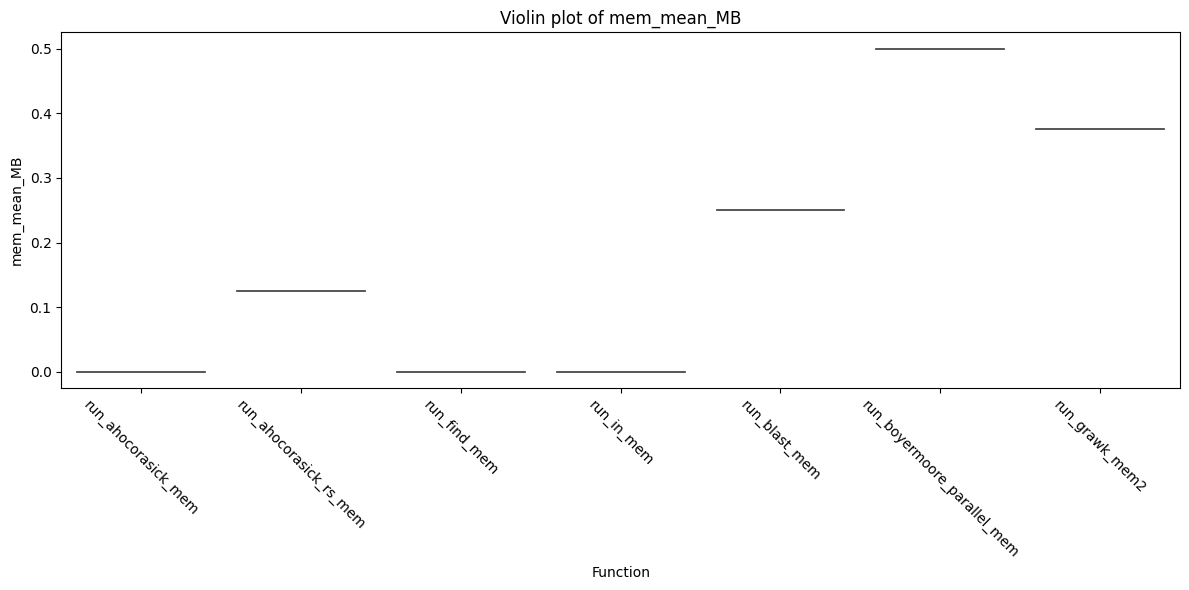

In [25]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

# Create a color palette - one color per function
functions = df_parallel["function"].unique()
#palette = sns.color_palette("husl", len(functions))
palette = dict(zip(functions, sns.color_palette("husl", len(functions))))


for m in metrics:
    # Boxplot with Seaborn using hue parameter
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x="function", y=m, data=df_parallel, hue="function", palette=palette, legend=False)
    plt.title(f"Boxplot of {m}")
    ax.set_xlabel("Function")
    ax.set_ylabel(m)
    plt.xticks(rotation=-45)
    plt.tight_layout()
    plt.show()

    # Violin plot with Seaborn
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x="function", y=m, data=df_parallel, hue="function", palette=palette, legend=False)
    plt.title(f"Violin plot of {m}")
    ax.set_xlabel("Function")
    ax.set_ylabel(m)
    plt.xticks(rotation=-45)
    plt.tight_layout()
    plt.show()

### Visualisation of results (boxplot + violin), in color + log(Y axis)

/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


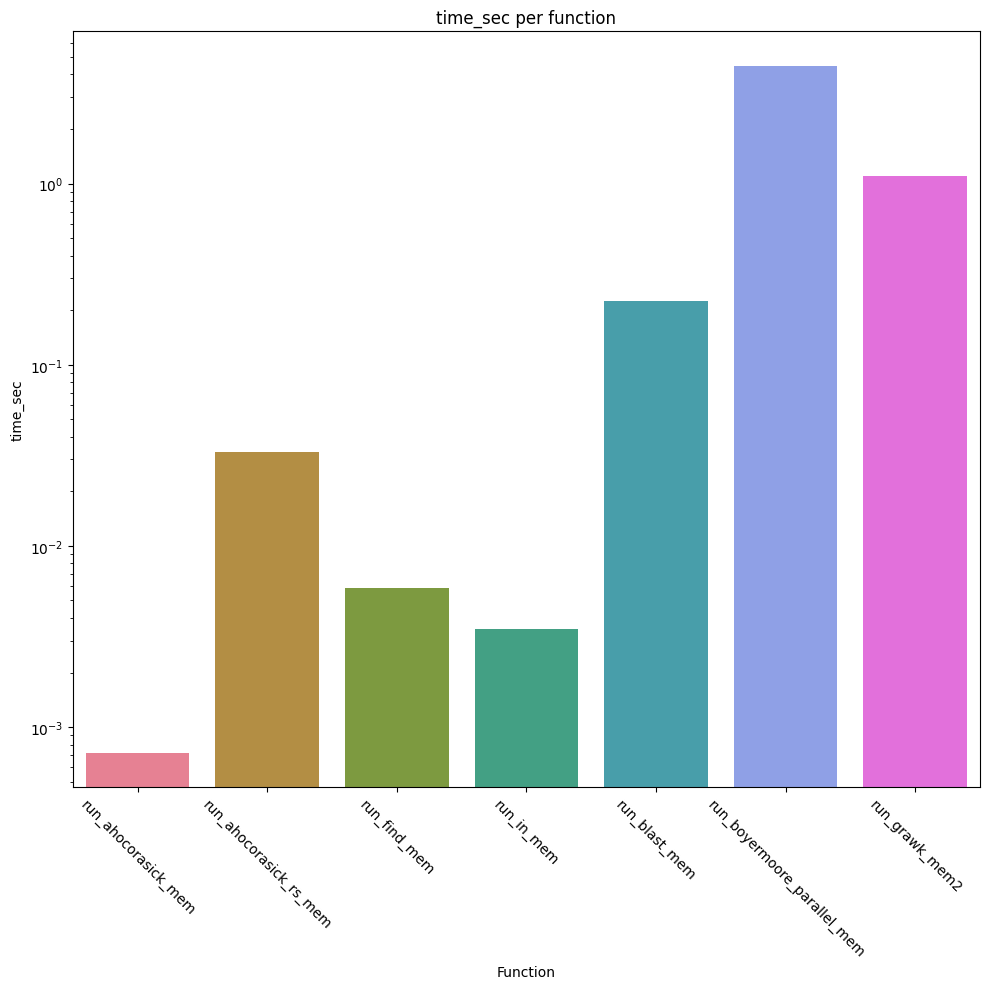

/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


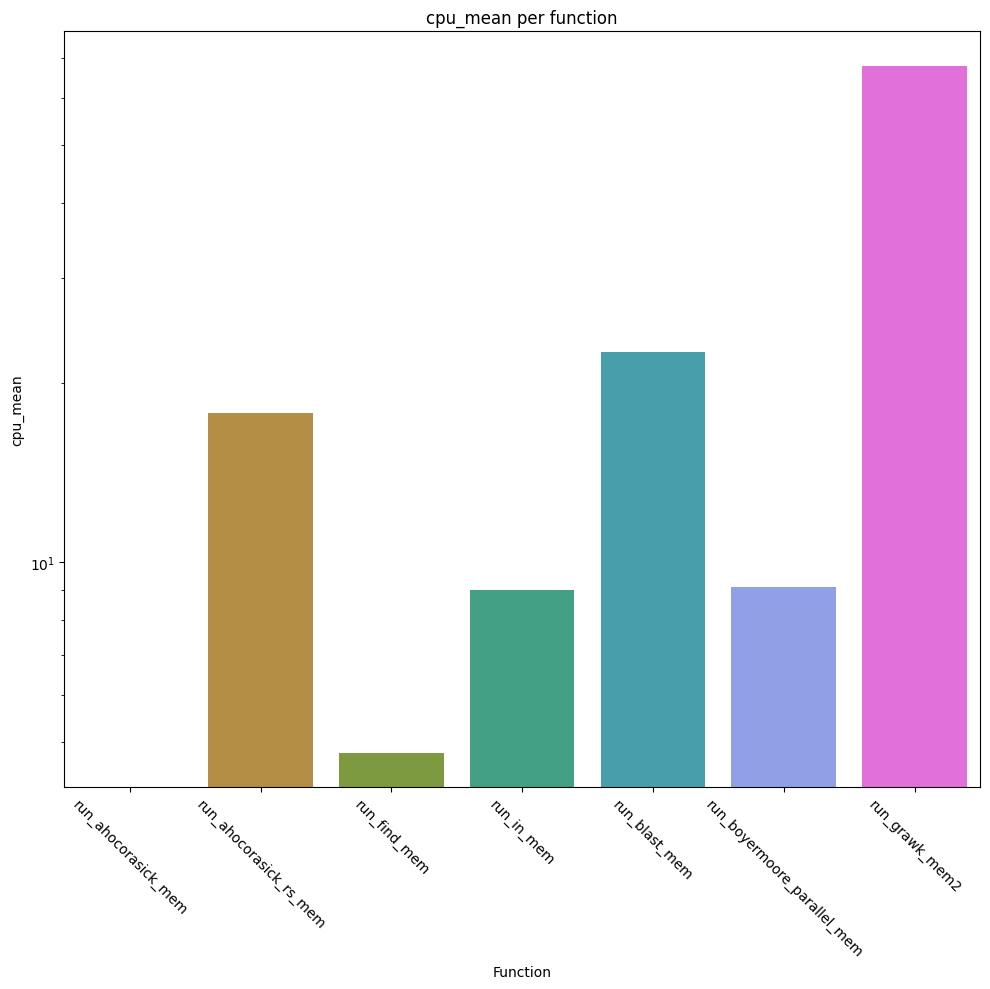

/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_24405/2588737714.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


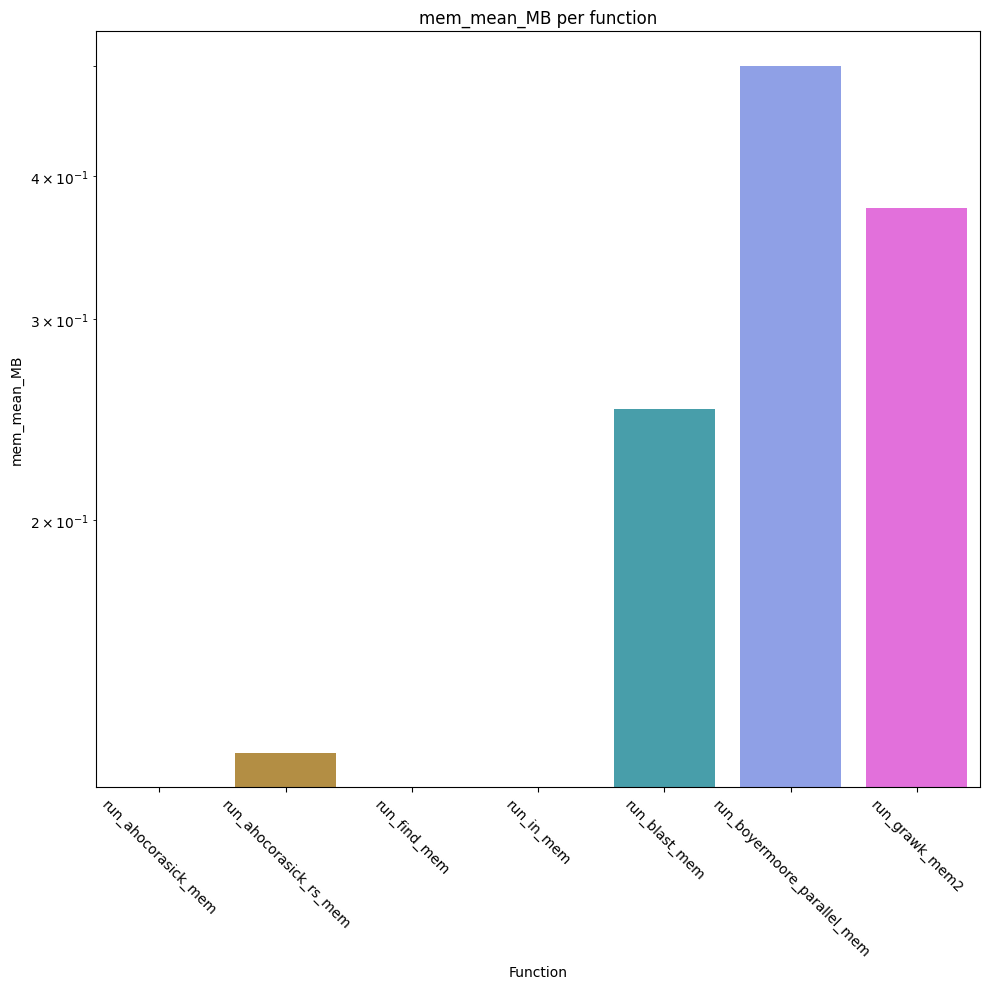

In [26]:
metrics = ["time_sec", "cpu_mean", "mem_mean_MB"]

# Palette fixe : une couleur par fonction
functions = df_parallel["function"].unique()
palette = dict(zip(functions, sns.color_palette("husl", len(functions))))

for m in metrics:
    plt.figure(figsize=(10, 10))
    # Barplot moyen ± écart type par fonction
    ax = sns.barplot(
        x="function",
        y=m,
        data=df_parallel,
        palette=palette,
        ci="sd"  # écart type pour barres d'erreur
    )

    ax.set_yscale("log")

    
    plt.title(f"{m} per function")
    plt.xlabel("Function")
    plt.xticks(rotation=-45)
    plt.ylabel(m)
    
    
    plt.tight_layout()
    plt.show()


### Export results

In [27]:
df_seq.to_csv("bench_seq.csv", index=False)
df_parallel.to_csv("bench_parallel.csv", index=False)
print("Benchmark exports complete.")


Benchmark exports complete.
